In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice

%load_ext autoreload
%matplotlib inline

<a list of 84 text.Text objects>

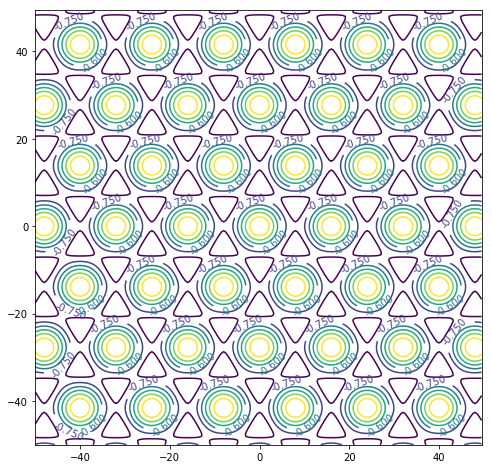

In [6]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

In [11]:
from walker import Graphene_Walker
walkers = Graphene_Walker(0.246, 10) # 2.46 Angstrom lattice, 10 Kelvin
tracks = walkers.get_tracks(moire, nsteps=300, njumps=10000, nparticles=10)
tracks.head()

/home/a/as/asai/Documents/moire_walk/walker.py:82: RuntimeWarning: invalid value encountered in true_divide
  total_time_normed = total_time / np.linalg.norm(total_time, np.inf, axis=1)[:, np.newaxis] * nsteps


NotImplementedError: previous is unsupported: Use fitpack routines for other types.